### Matterport 패키지를 이용하여 pretrained coco 모델을 로딩 후 단일 이미지와 영상 Segmentation 수행. 

### 본 실습 예제는 GPU를 활용하므로 상단 메뉴에서 런타임->런타임 유형 변경에서 GPU를 선택해 주십시요. 

ensorflow, keras 설치 및 강의 실습코드/데이터 Download

Colab 버전은 colab에서 pip 명령어를 이용하여 tensorflow 1.13, keras 2.2를 소스코드 커널 기동시 마다 설치해야 합니다

Colab의 tensorflow는 2020년 기준으로 2.2 이며, keras는 2.3입니다. 실습코드는 tensorflow 1.13과 1.15, keras 2.2 기준으로 되어 있으므로 이를 downgrade해야 합니다.

pip를 이용하여 tensorflow 1.13을 설치하면 자동으로 downgrade 됩니다.

OpenCV는 Colab에서 이미 설치 되어 있으니 추가설치는 필요 없습니다.

강의 실습코드와 데이터는 https://github.com/chulminkw/DLCV.git 에서 다운로드 할 수 있습니다. 

In [3]:
# 현재 디렉토리는 /content이며 이 디렉토리를 기준으로 실습코드와 데이터를 다운로드 합니다. 
!pwd
!git clone https://github.com/chulminkw/DLCV.git
# DLCV 디렉토리가 Download되고 DLCV 밑에 Detection과 Segmentation 디렉토리가 있는 것을 확인
!ls -lia 
!ls -lia DLCV

# tensorflow 1.13을 설치합니다. 자동으로 tensorflow 2.2가 1.13으로 downgrade 됩니다. 
!pip install tensorflow-gpu==1.15.2
# keras 2.2를 설치합니다. pip install keras==2.2.1 시 자동으로 2.3에서 2.2.1로 downgrade 됩니다. 
!pip install keras==2.3.0


/content
fatal: destination path 'DLCV' already exists and is not an empty directory.
total 20
1310745 drwxr-xr-x 1 root root 4096 Aug 11 07:35 .
2249441 drwxr-xr-x 1 root root 4096 Aug 11 07:33 ..
1310746 drwxr-xr-x 1 root root 4096 Aug  3 16:17 .config
4341619 drwxr-xr-x 6 root root 4096 Aug 11 07:35 DLCV
1179671 drwxr-xr-x 1 root root 4096 Jul 30 16:30 sample_data
total 820
4341619 drwxr-xr-x 6 root root   4096 Aug 11 07:35 .
1310745 drwxr-xr-x 1 root root   4096 Aug 11 07:35 ..
4341806 drwxr-xr-x 6 root root   4096 Aug 11 07:35 data
4341797 drwxr-xr-x 8 root root   4096 Aug 11 07:35 Detection
4341620 -rw-r--r-- 1 root root 807528 Aug 11 07:35 DLCV_Colab_SrcCode.zip
1988190 drwxr-xr-x 8 root root   4096 Aug 11 07:35 .git
4341640 -rw-r--r-- 1 root root    142 Aug 11 07:35 README.md
4341804 drwxr-xr-x 3 root root   4096 Aug 11 07:35 Segmentation
  Using cached https://files.pythonhosted.org/packages/71/e3/19762fdfc62877ae9102edf6342d71b28fbfd9dea3d2f96a882ce099b03f/Keras_Applications-

     |████████████████████████████████| 378kB 7.1MB/s 
  Found existing installation: Keras 2.2.1
    Uninstalling Keras-2.2.1:
      Successfully uninstalled Keras-2.2.1


In [2]:
# tensorflow는 1.13, keras는 2.2 버전 확인
# GPU가 세팅되어 있지 않으면 상단 메뉴에서 런타임->런타임 유형 변경에서 GPU를 선택한 후 런타임 다시 시작을 선택하고 처음 부터인 tensorflow, keras 설치 부터 다시 시작. 
import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)

# gpu가 세팅되어 있는지 확인. 
tf.test.gpu_device_name()

1.15.2
2.3.0


Using TensorFlow backend.


'/device:GPU:0'

#### Matterport Mask RCNN 패키지 다운로드및 설치 

In [3]:
# Mask_RCNN 다운로드 
%cd /content/DLCV/Segmentation/mask_rcnn
!git clone https://github.com/matterport/Mask_RCNN.git

# 다운로드한 Mask_RCNN 디렉토리로 이동하여 Mask_RCNN 패키지 설치. 
%cd /content/DLCV/Segmentation/mask_rcnn/Mask_RCNN
#!pip install -r requirements.txt
!python setup.py install

/content/DLCV/Segmentation/mask_rcnn
Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 116.77 MiB | 4.01 MiB/s, done.
Resolving deltas: 100% (564/564), done.
/content/DLCV/Segmentation/mask_rcnn/Mask_RCNN
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/li

In [4]:
import os
import sys
import random
import math
import numpy as np
import cv2

In [5]:
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

#### Matterport로 pretrained된 coco weight 모델을 다운로드함(최초시)
* 코랩 버전은 아래 코드로 pretrained 디렉토리를 재 생성해야함. 

In [6]:
!rm -rf /content/DLCV/Segmentation/mask_rcnn/pretrained
!mkdir /content/DLCV/Segmentation/mask_rcnn/pretrained

In [7]:
from mrcnn import utils

# 코랩 버전 수정
#ROOT_DIR = os.path.abspath('.')
ROOT_DIR = '/content/DLCV/Segmentation/mask_rcnn'
# 최초에는 coco pretrained 모델을 다운로드함. 
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "pretrained/mask_rcnn_coco.h5")

if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


In [8]:
!ls /content/DLCV/Segmentation/mask_rcnn/pretrained

mask_rcnn_coco.h5


#### MASK RCNN 모델을 위한 Config 설정

In [9]:
from mrcnn.config import Config

infer_config = Config()
infer_config.BATCH_SIZE=4
infer_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                13
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [10]:
# Config 클래스를 상속받아서 사용
from mrcnn.config import Config

#환경 변수는 모두 대문자 
class InferenceConfig(Config):
    # inference시에는 batch size를 1로 설정. 그리고 IMAGES_PER_GPU도 1로 설정. 
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # NAME은 반드시 주어야 한다. 
    NAME='coco_infer'
    NUM_CLASSES=81
    

infer_config = InferenceConfig()
infer_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

#### COCO ID와 클래스명 매핑

In [11]:
# matterport는 0을 Background로, 1부터 80까지 coco dataset 클래스 id/클래스 명 매핑. 
labels_to_names = {0:'BG',1: 'person',2: 'bicycle',3: 'car',4: 'motorbike',5: 'aeroplane',6: 'bus',7: 'train',8: 'truck',9: 'boat',10: 'traffic light',
                   11: 'fire hydrant',12: 'stop sign',13: 'parking meter',14: 'bench',15: 'bird',16: 'cat',17: 'dog',18: 'horse',19: 'sheep',20: 'cow',
                   21: 'elephant',22: 'bear',23: 'zebra',24: 'giraffe',25: 'backpack',26: 'umbrella',27: 'handbag',28: 'tie',29: 'suitcase',30: 'frisbee',
                   31: 'skis',32: 'snowboard',33: 'sports ball',34: 'kite',35: 'baseball bat',36: 'baseball glove',37: 'skateboard',38: 'surfboard',39: 'tennis racket',40: 'bottle',
                   41: 'wine glass',42: 'cup',43: 'fork',44: 'knife',45: 'spoon',46: 'bowl',47: 'banana',48: 'apple',49: 'sandwich',50: 'orange',
                   51: 'broccoli',52: 'carrot',53: 'hot dog',54: 'pizza',55: 'donut',56: 'cake',57: 'chair',58: 'sofa',59: 'pottedplant',60: 'bed',
                   61: 'diningtable',62: 'toilet',63: 'tvmonitor',64: 'laptop',65: 'mouse',66: 'remote', 67: 'keyboard',68: 'cell phone',69: 'microwave',70: 'oven',
                   71: 'toaster',72: 'sink',73: 'refrigerator',74: 'book',75: 'clock',76: 'vase',77: 'scissors',78: 'teddy bear',79: 'hair drier',80: 'toothbrush' }

In [12]:
# MS-COCO 기반으로 Pretrained 된 모델을 로딩
import mrcnn.model as modellib

MODEL_DIR = os.path.join(ROOT_DIR,'snapshots') 
print(MODEL_DIR)
model = modellib.MaskRCNN(mode="inference",  model_dir=MODEL_DIR, config=infer_config)

model.load_weights(COCO_MODEL_PATH, by_name=True)

/content/DLCV/Segmentation/mask_rcnn/snapshots
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [13]:
import matplotlib.pyplot as plt
%matplotlib inline 

default_dir = '/content/DLCV'
beatles_img = cv2.imread(os.path.join(default_dir, 'data/image/beatles01.jpg'))
# matterport는 내부적으로 image처리를 위해 skimage를 이용하므로 BGR2RGB처리함. 
beatles_img_rgb = cv2.cvtColor(beatles_img, cv2.COLOR_BGR2RGB)
 
results = model.detect([beatles_img_rgb], verbose=1)

Processing 1 images
image                    shape: (633, 806, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32



In [14]:
len(results), results[0]

(1,
 {'class_ids': array([1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int32),
  'masks': array([[[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False]],
  
         [[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False]],
  
         [[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, 

In [15]:
# results[0]['masks']는 object 별로 mask가 전체 이미지에 대해서 layered된 image 배열을 가지고 있음.  
results[0]['rois'].shape, results[0]['scores'].shape, results[0]['class_ids'].shape, results[0]['masks'].shape

((18, 4), (18,), (18,), (633, 806, 18))

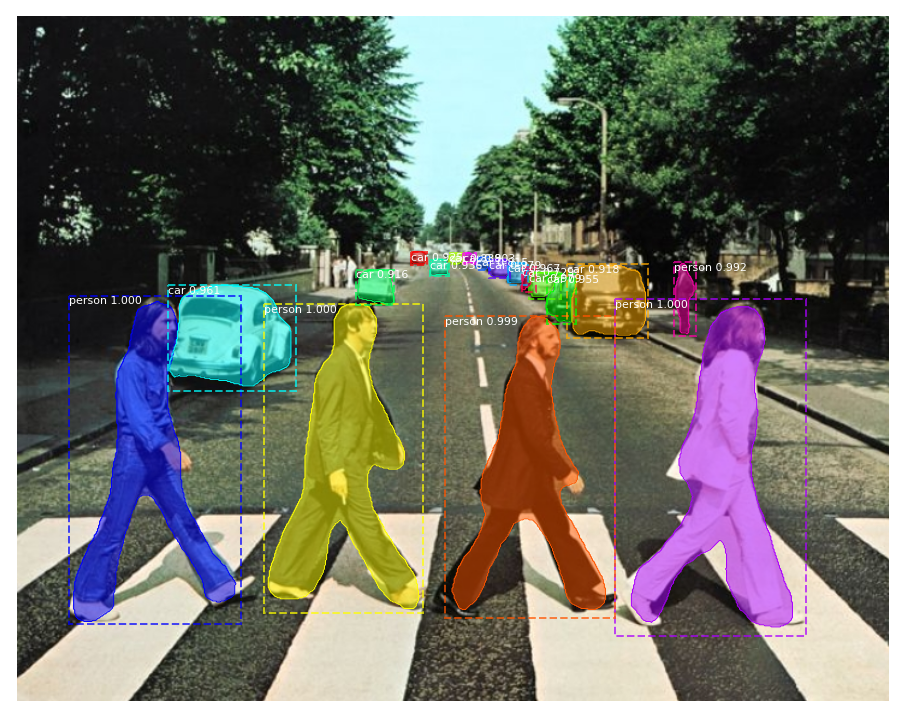

In [16]:
from mrcnn import visualize

r = results[0]
class_names = [value for value in labels_to_names.values()]
visualize.display_instances(beatles_img_rgb, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

Processing 1 images
image                    shape: (450, 814, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
## inference time:0.8556468486785889


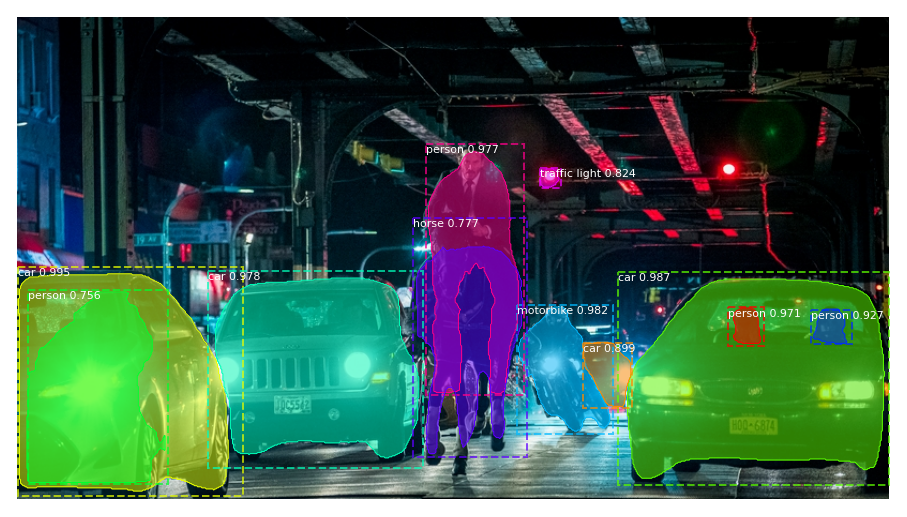

In [17]:
import time

wick_img = cv2.imread(os.path.join(default_dir, 'data/image/john_wick01.jpg'))
wick_img_rgb = cv2.cvtColor(wick_img, cv2.COLOR_BGR2RGB)

def get_segment_result(img_array_list, verbose):
    
    start_time = time.time()
    results = model.detect(img_array_list, verbose=1)
    
    if verbose==1:
        print('## inference time:{0:}'.format(time.time()-start_time))
    
    return results

r = get_segment_result([wick_img_rgb], verbose=1)[0]
visualize.display_instances(wick_img_rgb, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

### Video에 Segmentation 적용 
* MaskRCNN 패키지는 visualize.display_instances() 함수내부에서 matplotlib를 이용하여 자체 시각화를 수행. 
* Video segment instance에 적용하기 위해서 bounding box와 instance masking을 적용하는 별도의 함수 생성. 

In [18]:
from mrcnn.visualize import *
import cv2

def get_segmented_image(img_array, boxes, masks, class_ids, class_names,
                      scores=None, show_mask=True, show_bbox=True, colors=None, captions=None):
   
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]
    

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = img_array.shape[:2]

    masked_image = img_array.astype(np.uint32).copy()

    for i in range(N):
        color = np.array(colors[i])*255
        color = color.tolist()

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        
        if show_bbox:
            cv2.rectangle(img_array, (x1, y1), (x2, y2), color, thickness=1 )

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
            
        cv2.putText(img_array, caption, (x1, y1+8), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), thickness=1)
        
        # Mask
        # 클래스별 mask 정보를 추출 
        mask = masks[:, :, i]
        if show_mask:
            # visualize 모듈의 apply_mask()를 적용하여 masking 수행.
            img_array = apply_mask(img_array, mask, color)
            
            # mask에 contour 적용. 
            padded_mask = np.zeros(
                            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
            padded_mask[1:-1, 1:-1] = mask
            contours = find_contours(padded_mask, 0.5)
            for verts in contours:
                # padding 제거. 아래에서 verts를 32bit integer로 변경해야 polylines()에서 오류 발생하지 않음. 
                verts = verts.astype(np.int32)
                #x, y 좌표 교체
                verts = np.fliplr(verts) - 1
                cv2.polylines(img_array, [verts], True, color, thickness=1)
    
    return img_array


####  단일 IMAGE에 적용

Processing 1 images
image                    shape: (450, 814, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
## inference time:0.7687461376190186


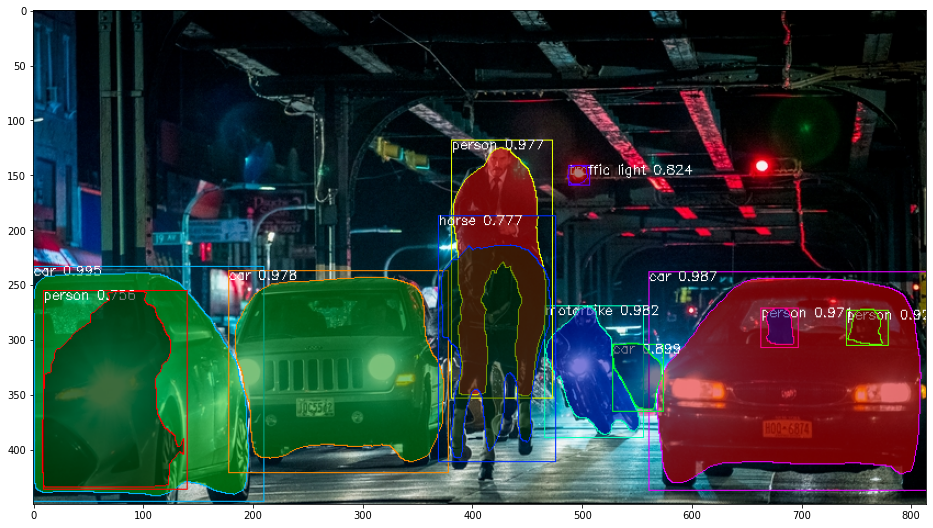

In [19]:
import time

wick_img = cv2.imread(os.path.join(default_dir, 'data/image/john_wick01.jpg'))
wick_img_rgb = cv2.cvtColor(wick_img, cv2.COLOR_BGR2RGB)

r = get_segment_result([wick_img_rgb], verbose=1)[0]
segmented_img = get_segmented_image(wick_img_rgb, r['rois'], r['masks'], r['class_ids'], 
                                    class_names, r['scores'])

plt.figure(figsize=(16, 16))
plt.imshow(segmented_img)

#### Video Segmentation 적용

In [20]:
import time

video_input_path = os.path.join(default_dir, 'data/video/John_Wick_small.mp4')
# video output 의 포맷은 avi 로 반드시 설정 필요. 
video_output_path = os.path.join(default_dir, 'data/output/John_Wick_small_matterport01.avi')

cap = cv2.VideoCapture(video_input_path)
codec = cv2.VideoWriter_fourcc(*'XVID')
fps = round(cap.get(cv2.CAP_PROP_FPS))

vid_writer = cv2.VideoWriter(video_output_path, codec, fps, (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("총 Frame 개수: {0:}".format(total))

frame_index = 0
while True:
    
    hasFrame, image_frame = cap.read()
    if not hasFrame:
        print('End of frame')
        break
    
    frame_index += 1
    print("frame index:{0:}".format(frame_index), end=" ")
    r = get_segment_result([image_frame], verbose=1)[0]
    segmented_img = get_segmented_image(image_frame, r['rois'], r['masks'], r['class_ids'], 
                                    class_names, r['scores'])
    vid_writer.write(segmented_img)
    
vid_writer.release()
cap.release()       

총 Frame 개수: 58
frame index:1 Processing 1 images
image                    shape: (460, 1072, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1072.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
## inference time:0.7291820049285889
frame index:2 Processing 1 images
image                    shape: (460, 1072, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1072.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
## inference time:0.7158157825469971
frame index:3 Processing 1 images
image                    shape: (460, 1072, 3

In [ ]:
## colab 버전은 Object Detection 적용된 영상 파일을 google drive에서 download 해야 합니다. 이를 위해 google drive를 colab에 mount 수행. 
import os, sys 
from google.colab import drive 

drive.mount('/content/gdrive')

In [ ]:
## colab 버전은 Object Detection 적용된 영상 파일을 google drive에서 download 해야 합니다. 
## My Drive 디렉토리 이름에 공란이 있으므로 ' '로 묶습니다. 
!cp /content/DLCV/data/output/John_Wick_small_matterport01.avi '/content/gdrive/My Drive/John_Wick_small_matterport01.avi'

#### 다른 동영상에 적용. 

In [ ]:
video_input_path = os.path.join(default_dir, 'data/video/London_Street.mp4')
# video output 의 포맷은 avi 로 반드시 설정 필요. 
video_output_path = os.path.join(default_dir, 'data/output/London_Street_matterport01.avi')

cap = cv2.VideoCapture(video_input_path)
codec = cv2.VideoWriter_fourcc(*'XVID')
fps = round(cap.get(cv2.CAP_PROP_FPS))
vid_writer = cv2.VideoWriter(video_output_path, codec, fps, (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("총 Frame 개수: {0:}".format(total))

import time

frame_index = 0
while True:
    
    hasFrame, image_frame = cap.read()
    if not hasFrame:
        print('End of frame')
        break
    
    frame_index += 1
    print("frame index:{0:}".format(frame_index), end=" ")
    r = get_segment_result([image_frame], verbose=1)[0]
    segmented_img = get_segmented_image(image_frame, r['rois'], r['masks'], r['class_ids'], 
                                    class_names, r['scores'])
    vid_writer.write(segmented_img)
    
vid_writer.release()
cap.release()       


In [ ]:
## colab 버전은 Object Detection 적용된 영상 파일을 google drive에서 download 해야 합니다. 
## My Drive 디렉토리 이름에 공란이 있으므로 ' '로 묶습니다. 
!cp /content/DLCV/data/output/London_Street_matterport01.avi '/content/gdrive/My Drive/London_Street_matterport01.avi'